# Decision Tree Algorithm (From Scratch)
# Created By: Michael Eiger and Sean Daylor

In [262]:
# Import the packages necessary for both tree implementation and conducting the data analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from sklearn.metrics import confusion_matrix

# Part 1: Decision Tree Implementation

### General Solution for Implementation:
* Create a class that will create instances of the object type "DecisionTree"

    * Initialize the "DecisionTree" object's state (*__NOTE__: see ___ _init_ ___*)
        * Take two arguments - (1) the feature values and (2) the target labels
        * Establishes four attributes for the object - (1) the object containing a data set, (2) target labels, (3) target entropy and (4) a dictionary that will ultimately store the decision tree's hierarchy
 
    * Create a class method that will calculate entropy through the use of a frequency table (*__NOTE__: see ___entropy__*)
        * Take two arguments - (1) an argument that will be used to only calculate entropy on the target labels and (2) an argument that will be used to calculate entropy on the target labels versus the feature/predictor values (*NOTE: Both arguments are initiatlized as a NoneType value before being passed to store a finite frequency from which entropy is calculated*)  
        * Calculates entropy for one attribute OR two attributes, then returns a float representing entropy
        
    * Create a class method that will calculate information gain (*__NOTE__: see ___information_gain__*)
        * Take one argument - (1) a calculated entropy value relative to an attribute(s)
        * Return a float representing information gain
        
    * Create a class method that will determine the column for best split based on information gain (*__NOTE__: see ___best_split__*)
        * Take one argument - (1) the object containing a data set
        * Return a key from a dictionary object that has the greatest (i.e., most-frequently occurring) associated value within said dictionary
        
    * Create a class method that will recursively build a ID3 decision tree (*__NOTE__: see ___grow_tree__*)
        * Take two arguments - (1) the object containing a data set and (2) a variable initialized as a NoneType that will eventually store the on which the decision tree's hiearchy 
        * Return a dictionary-type object containing the hierarchy for the decision tree object, including the decision tree object's nodes

    * Create a class method that will recursively predict target labels using the trained decision tree (*__NOTE__: see ___make_prediction__*)
        * Take two arguments - (1) a dictionary that will store optimal nodes and (2) a dictionary in which the tree's hiearchy will be built 
        * Return a predicted target label after each step of recursion
         
    * Create a class method that will train the DecisionTree object on the training data (*__NOTE__: see __train__*)
        * Take no arguments
        * Do not return a value, but store the recursively built ID3 decision tree as one of the DecisionTree object's attributes
        
    * Create a class method that will train the DecisionTree object with the training data based on the data set/target labels passed during class initialization (*__NOTE__: see __predict__*)
        * Take no arguments
        * Return the data frame storing the predicted labels and actual labels for each row of the test data AND a float representing the accuracy of the classifier when predicting target labels from the test set

In [263]:
class DecisionTree:
  def __init__(self, data, target):
    self.data = data
    self.target = target
    # Calculate dataset entropy for Information Gain
    self.target_entropy = self._entropy(value_counts=self.target.value_counts())
    # Store instance's decision tree as attribute
    self.tree = {}
    # Temporary attribute for subset recursion
    self.tmp = None

  def _entropy(self, value_counts=None, freq=None):
    """ Calculate entropy via frequency table """
    # Calculate entropy for one attribute
    if value_counts is not None:
      return entropy(value_counts, base=2)
    # Calculate entropy for two attributes
    elif freq is not None:
      feature_ent = 0
      # For every unique feature class in subset, calculate entropy and
      # proportionally add it to feature's entropy
      for class_ in freq.drop("Sum", axis=0).index.values:
        class_ent = self._entropy(freq.drop("Sum", axis=1).loc[class_])
        p = (freq.loc[class_]["Sum"]) / (freq.loc["Sum"]["Sum"])
        feature_ent += (class_ent*p)
      return feature_ent

  def _information_gain(self, feature_entropy):
    """ Calculate Information Gain """
    # Subtract feature's entropy from dataset entropy
    return self.target_entropy - feature_entropy

  def _best_split(self, data):
    """ Determine column for best split via Information Gain """
    ig_dict = {}
    # For every feature create a frequency table with target variable,
    # calculate the entropy and return the feature with the largest information
    # gain as the decision node
    for feature in data.drop(self.target.name, axis=1):
      freq = pd.crosstab(index=self.target, columns=data[feature], margins=True, margins_name="Sum").T
      ig_dict[feature] = self._information_gain(self._entropy(freq=freq))
    return max(ig_dict, key=ig_dict.get)

  def _grow_tree(self, data, tree=None):
    """ Recursively build ID3 decision tree """
    # Determine the decision node
    node = self._best_split(data)

    # Recursively build tree attribute
    if tree is None:
      tree={}
      tree[node] = {}

    # For every unique class value in subset filtered by decision node, filter by
    # the unique class and determine if entropy is 0
    for unique in data[node].unique():
      subset = data.loc[(data[node] == unique)]
      counts = subset[self.target.name].value_counts()

      # If entropy is 0 or no more features to split on, record a leaf
      if len(counts) == 1 or subset.equals(self.tmp):
        tree[node][unique] = counts.index[0]
      # Otherwise, record new branch and continue splitting
      else:
        self.tmp = subset
        tree[node][unique] = self._grow_tree(subset)

    return tree

  def _make_prediction(self, record, tree):
    """ Recursively predict target using trained decision tree """
    # Recursively traverse decision tree on test observation
    for node in tree.keys():
      value = record[node]
      # If branch does not exist, return dataset's most probable target
      try:
        tree = tree[node][value]
      except KeyError:
        return self.target.value_counts().index[0]

      # If type(tree) is dictionary, continue traversing tree
      if type(tree) is dict:
        pred = self._make_prediction(record, tree)
      # Otherwise, we've found a leaf, return
      else:
        pred = tree
      break
    return pred

  def train(self):
    """ Method to train decision tree given initialized data and target variable """
    self.tree = self._grow_tree(self.data)

  def predict(self, x_test, y_test):
    """ Train the DecisionTree object with the training data based on the data set/target labels passed """
    # Apply lambda function to determine prediction row-wise on DataFrame object
    x_test["prediction"] = x_test.apply(lambda x: self._make_prediction(x, self.tree), axis=1)
    # Add the actual target value
    x_test["actual"] = y_test
    # Determine accuracy by checking if 'prediction' column matches 'actual' column
    accuracy = (sum(x_test.apply(lambda x: 1 if x.actual == x.prediction else 0, axis=1)) / len(x_test))
    return x_test, accuracy

# Part 2: Titanic Data Set

## Data Preprocessing/Analysis (Titanic)

#### Read in the data set and establish its dimensions/missing values

In [264]:
# Read in the Titanic data set
df = pd.read_csv("https://raw.githubusercontent.com/URI-CSC/461-fall-2020/master/assignments/assignment-1/titanic.csv")

# Establish the dimensions of the Titantic data set
print("Dimensions of the Titanic data set (BEFORE dropping the 'Name' column): " + str(df.shape))
print("")

# Drop the identifier variable 'Name', which will have no impact on the decision tree's ability to predict the target labels
df = df.drop('Name', axis=1)
print("Dimensions of the Titanic data set (AFTER dropping the 'Name' column): " + str(df.shape))
print("")

# Preemptively drop any rows with missing values from the data frame
df = df.dropna(axis=0)
df.reset_index(drop=True)

# Determine if any rows were dropped due to at least one column within said row having a missing value
print("Dimensions of the Titanic data set (AFTER dropping the 'Name' column AND dropping rows with missing values): " + str(df.shape))

Dimensions of the Titanic data set (BEFORE dropping the 'Name' column): (887, 8)

Dimensions of the Titanic data set (AFTER dropping the 'Name' column): (887, 7)

Dimensions of the Titanic data set (AFTER dropping the 'Name' column AND dropping rows with missing values): (887, 7)


**Based on the above output:**

- BEFORE dropping the identifier column 'Name', the dimensions of the Titanic data set were: 887 rows and 8 columns
    - Representing 887 passengers across 8 variables

- AFTER dropping the identifier column 'Name', the dimensions of the Titanic data set were: 887 rows and 7 columns
    - Representing 887 passengers across 7 variables

- AFTER dropping the 'Name' column AND dropping rows with missing values, the dimensions of the Titanic data set were: 887 rows and 7 columns
  - *(NOTE: Since no rows were dropped, this result indicates that no rows were missing values.)*

#### Identify the (non-identifier) variables in the Titanic data frame

In [265]:
# Identify the remaining variables in the data frame
print("A list of remaining variables in the Titanic data frame and each column's respective value type:")
print("")
print(df.dtypes)

A list of remaining variables in the Titanic data frame and each column's respective value type:

Survived                     int64
Pclass                       int64
Sex                         object
Age                        float64
Siblings/Spouses Aboard      int64
Parents/Children Aboard      int64
Fare                       float64
dtype: object


**Based on the above output:**

The Titanic data set contains the following seven variables after dropping the 'Name' column:
1. Survived
2. Pclass
3. Sex
4. Age
5. Siblings/Spouses Aboard
6. Parents/Children Aboard
7. Fare

Each column will be converted into a string type later in the program but prior to training the classifier model to ensure compability with the decision tree implementation.

***NOTE: Each variable will be further processed and analayzed in the subsequent cells.***

#### Variable 1: Survived

The data type of values in this column: int64

The list of unique values among all records in this column: [0 1]

The class distribution of values in this column: 
Survived
0    545
1    342
dtype: int64

Class Distribution Bar Chart:


(0.0, 600.0)

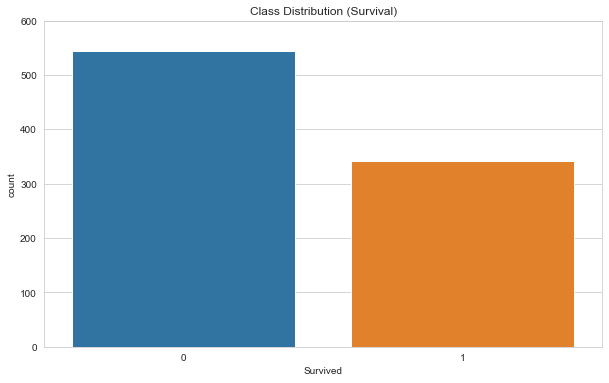

In [266]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df['Survived'].dtypes))
print("")

# Identify all of the unique values among records in this column
survived = df['Survived'].unique()
survived.sort()
print("The list of unique values among all records in this column: " + str(survived))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column: ")
print(df.groupby('Survived').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
sns.set_style('whitegrid')
plt.subplots(figsize=(10,6))
sns.countplot(x = 'Survived', data = df, order = df['Survived'].value_counts().index).set_title("Class Distribution (Survival)")
plt.ylim(0, 600)

**Based on the above output:**

Variable #1: Survived
- Column Type: Int
- Two unique values: 0 and 1
- Class distribution: 0 occurs 545 times, 1 occurs 342 times
- Variable description: A discrete and binary response variable that indicates whether a given passenger survived the Titanic disaster or not. A value of 1 indicates that the passenger survived while a value of 0 indicates that the passenger did not survive.

#### Variable 2: Pclass

The data type of values in this column: int64

The list of unique values among all records in this column: [1 2 3]

The class distribution of values in this column:
Pclass
1    216
2    184
3    487
dtype: int64

Class Distribution Bar Chart:


(0.0, 500.0)

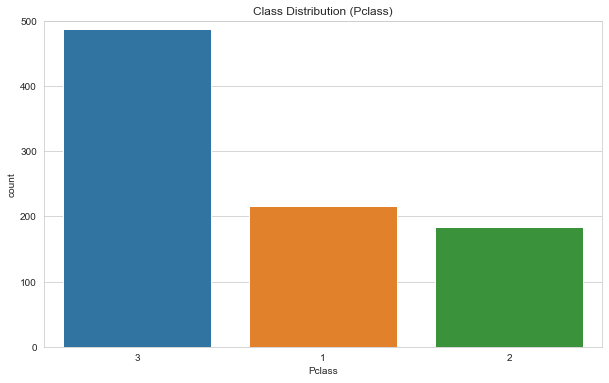

In [267]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df['Pclass'].dtypes))
print("")

# Identify all of the unique values among records in this column
pclass = df['Pclass'].unique()
pclass.sort()
print("The list of unique values among all records in this column: " + str(pclass))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df.groupby('Pclass').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
plt.subplots(figsize=(10,6))
sns.countplot(x = 'Pclass', data = df, order = df['Pclass'].value_counts().index).set_title("Class Distribution (Pclass)")
plt.ylim(0, 500)

**Based on the above output:**

Variable #2: Pclass
- Column Type: Int
- Three unique values: 1, 2, and 3
- Class distribution: 1 occurs 216 times, 2 occurs 184 times, 3 occurs 487 times
- Variable description: A discrete and ternary predictor variable that indicates the ticket class of a given passenger aboard the Titanic. A value of 1 indicates that the passenger was in the 1st ticket class, a value of 2 indicates that the passenger was 2nd ticket class, and a value of 3 indicates that the passenger was in the 3rd ticket class.

#### Variable 3: Sex

The data type of values in this column: object

The list of unique values among all records in this column: ['female' 'male']

The class distribution of values in this column:
Sex
female    314
male      573
dtype: int64

Class Distribution Bar Chart:


(0.0, 600.0)

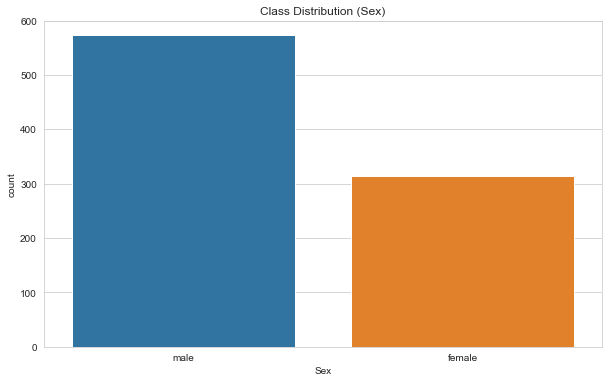

In [268]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df['Sex'].dtypes))
print("")

# Identify all of the unique values among records in this column
sex = df['Sex'].unique()
sex.sort()
print("The list of unique values among all records in this column: " + str(sex))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df.groupby('Sex').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
plt.subplots(figsize=(10,6))
sns.countplot(x = 'Sex', data = df, order = df['Sex'].value_counts().index).set_title("Class Distribution (Sex)")
plt.ylim(0, 600)

**Based on the above output:**

Variable #3: Sex
- Column Type: Object
- Two unique values: 'Female' and 'Male'
- Class distribution: Female occurs 314 times, Male occurs 573 times
- Variable description: Represented in the data set as a binary predictor variable with string-type objects representing one of two distinct groups: female or male. A value of 'female' indicates that a passenger was female while a value of 'male' indicates that the passenger was male.

#### Variable 4: Age

The data type of values in this column: float64

The list of unique values among all records in this column:
[ 0.42  0.67  0.75  0.83  0.92  1.    2.    3.    4.    5.    6.    7.
  8.    9.   10.   11.   12.   13.   14.   14.5  15.   16.   17.   18.
 19.   20.   20.5  21.   22.   23.   23.5  24.   24.5  25.   26.   27.
 28.   28.5  29.   30.   30.5  31.   32.   32.5  33.   34.   34.5  35.
 36.   36.5  37.   38.   39.   40.   40.5  41.   42.   43.   44.   45.
 45.5  46.   47.   48.   49.   50.   51.   52.   53.   54.   55.   55.5
 56.   57.   58.   59.   60.   61.   62.   63.   64.   65.   66.   69.
 70.   70.5  71.   74.   80.  ]

Summary statistics for this column:
count    887.000000
mean      29.471443
std       14.121908
min        0.420000
25%       20.250000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


Text(0.5, 0, 'Age (in Years)')

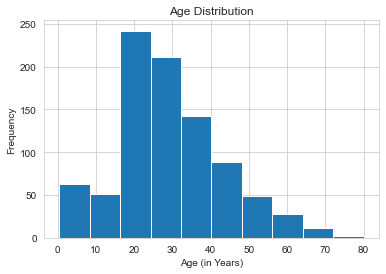

In [269]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df['Age'].dtypes))
print("")

# Identify all of the unique values among records in this column
age = df['Age'].unique()
age.sort()
print("The list of unique values among all records in this column:")
print(age)
print("")

# Summary statistics for this column
print("Summary statistics for this column:")
print(df['Age'].describe())

# Histogram to view the shape of the column's value distribution curve
df['Age'].hist(bins = 10)
plt.title('Age Distribution')
plt.ylabel('Frequency')
plt.xlabel('Age (in Years)')

**Summary Statistics for Age (Pre-Discretization)**
- Mean Age: 29.471443 years old
- Standard Deviation: 14.121908 years
- Minimum Age: 0.42 years old
- Maximum Age: 80 years old
- 25th Percentile: 20.25 years old
- 50th Percentile (i.e., Median): 28 years old
- 75th Percentile: 38 years old

- ** Because the column's mean is greater than its median, the column's value distribution exhibited positive-skewedness.

**NOTE:** Because the variable 'Age' is a float type column with and thus has continuous values, discretization will be performed in the following cell to ensure that values in this column are more easily interpretable when read into the decision tree classifier. 

The NEW data type of values in this column: Category

The NEW list of unique values among all records in this column: [0 1 2 3]

The class distribution of values in this column:
Age
0    222
1    243
2    208
3    214
dtype: int64

Class Distribution Histogram:


Text(0, 0.5, 'Frequency')

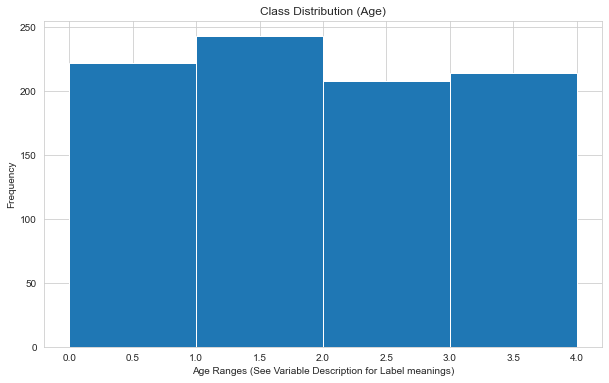

In [270]:
# Discretize the continuous values by binning them
df['Age'] = pd.qcut(df['Age'], q=4, labels=[0, 1, 2, 3], duplicates="drop")

# Reevaluate the data type of values in this column
print("The NEW data type of values in this column: " + str(df['Age'].dtypes).capitalize())
print("")

# Reevaluate all of the unique values among records in this column
df['Age'] = df['Age'].astype(int) # To enable unique values to be sorted via .sort()
age = df['Age'].unique()
age.sort()
print("The NEW list of unique values among all records in this column: " + str(age))
print("")

# Generate a class distribution for binned values in this column
print("The class distribution of values in this column:")
print(df.groupby('Age').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Histogram:""")
plt.subplots(figsize=(10,6))
plt.hist(df['Age'], bins = 4, range = (0,4))
plt.title('Class Distribution (Age)')
plt.xlabel('Age Ranges (See Variable Description for Label meanings)')
plt.ylabel('Frequency')

**Based on the above output:**

Variable #4: Age (POST-DISCRETIZATION)
- Column Type: Category
- Four unique values: 0, 1, 2, and 3
- Class distribution: 0 occurs 222 times, 1 occurs 243 times, 2 occurs 208 times, 3 occurs 214 times
- Variable description: Originally represented in the data set as a continuous predictor variable with values being indicative of a Titanic passenger's age in years. However, the decision tree model benefits from being given discrete variables for each stage of implementation. To discretize the Age values into an easily interpretable form, all continuous values were first divided into four separate bins with each bin representing a percentile range (0 = 0th - 25th percentile, 1 = 26th to 50th percentile, 2 = 51st to 75th percentile, 3 = 76th to 100th percentile) of ages from the span of all values originally in the column.

#### Variable 5: Siblings/Spouses Aboard

The data type of values in this column: int64

The list of unique values among all records in this column: [0 1 2 3 4 5 8]

The class distribution of values in this column:
Siblings/Spouses Aboard
0    604
1    209
2     28
3     16
4     18
5      5
8      7
dtype: int64

Class Distribution Bar Chart:


Text(0.5, 1.0, 'Class Distribution (Siblings/Spouses Aboard)')

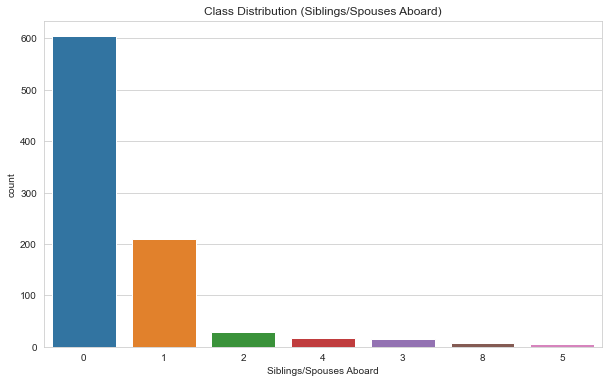

In [271]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df['Siblings/Spouses Aboard'].dtypes))
print("")

# Identify all of the unique values among records in this column
siblings_spouses = df['Siblings/Spouses Aboard'].unique()
siblings_spouses.sort()
print("The list of unique values among all records in this column: " + str(siblings_spouses))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df.groupby('Siblings/Spouses Aboard').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
plt.subplots(figsize=(10,6))
sns.countplot(x = 'Siblings/Spouses Aboard', data = df, order = df['Siblings/Spouses Aboard'].value_counts().index).set_title("Class Distribution (Siblings/Spouses Aboard)")

**Based on the above output:**

Variable #5: Siblings/Spouses Aboard
- Column Type: Int
- Seven unique values: 0, 1, 2, 3, 4, 5, and 8
- Class distribution: 0 occurs 604 times, 1 occurs 209 times, 2 occurs 28 times, 3 occurs 16 times, 4 occurs 18 times, 5 occurs 5 times, and 8 occurs 7 times
- Variable description: A discrete predictor variable whose values indicate how many siblings/spouses that a given passenger had aboard the Titanic. A value of 0 indicates that a passenger had 0 siblings/spouses aboard the ship, a value of 1 indicates that a passenger had 1 sibling/spouse aboard the ship, and so on.

#### Variable 6: Parents/Children Aboard

The data type of values in this column: int64

The list of unique values among all records in this column: [0 1 2 3 4 5 6]

The class distribution of values in this column:
Parents/Children Aboard
0    674
1    118
2     80
3      5
4      4
5      5
6      1
dtype: int64

Class Distribution Bar Chart:


Text(0.5, 1.0, 'Class Distribution (Parents/Children Aboard)')

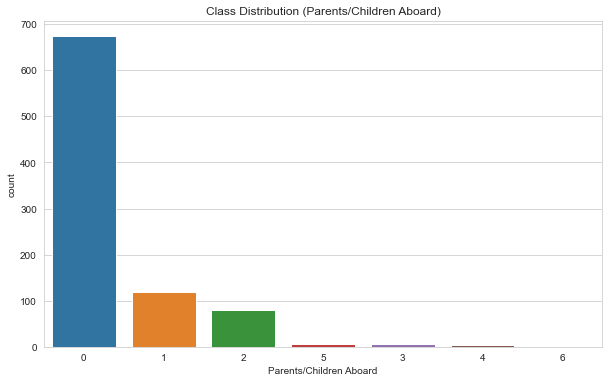

In [272]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df['Parents/Children Aboard'].dtypes))
print("")

# Identify all of the unique values among records in this column
parents_children = df['Parents/Children Aboard'].unique()
parents_children.sort()
print("The list of unique values among all records in this column: " + str(parents_children))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df.groupby('Parents/Children Aboard').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
plt.subplots(figsize=(10,6))
sns.countplot(x = 'Parents/Children Aboard', data = df, order = df['Parents/Children Aboard'].value_counts().index).set_title("Class Distribution (Parents/Children Aboard)")

**Based on the above output:**

Variable #6: Parents/Children Aboard
- Column Type: Int
- Seven unique values: 0, 1, 2, 3, 4, 5, and 6
- Class distribution: 0 occurs 674 times, 1 occurs 118 times, 2 occurs 80 times, 3 occurs 5 times, 4 occurs 4 times, 5 occurs 5 times, and 6 occurs 1 time
- Variable description: A discrete predictor variable whose values indicate how many parents/children that a given passenger had aboard the Titanic. A value of 0 indicates that a passenger had 0 parents/children aboard the ship, a value of 1 indicates that a passenger had 1 parent/child aboard the ship, and so on.

#### Variable 7: Fare

The data type of values in this column: float64

The list of unique values among all records in this column:
[  0.       4.0125   5.       6.2375   6.4375   6.45     6.4958   6.75
   6.8583   6.95     6.975    7.0458   7.05     7.0542   7.125    7.1417
   7.225    7.2292   7.25     7.3125   7.4958   7.5208   7.55     7.6292
   7.65     7.725    7.7292   7.7333   7.7375   7.7417   7.75     7.775
   7.7875   7.7958   7.8      7.8292   7.8542   7.875    7.8792   7.8875
   7.8958   7.925    8.0292   8.05     8.1125   8.1375   8.1583   8.3
   8.3625   8.4042   8.4333   8.4583   8.5167   8.6542   8.6625   8.6833
   8.7125   8.85     9.       9.2167   9.225    9.35     9.475    9.4833
   9.5      9.5875   9.825    9.8375   9.8417   9.8458  10.1708  10.4625
  10.5     10.5167  11.1333  11.2417  11.5     12.      12.275   12.2875
  12.35    12.475   12.525   12.65    12.875   13.      13.4167  13.5
  13.7917  13.8583  13.8625  14.      14.1083  14.4     14.4542  14.4583
  14.5     15.      15.0

Text(0.5, 0, 'Fare (in USD)')

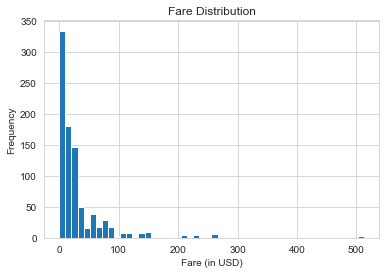

In [273]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df['Fare'].dtypes))
print("")

# Identify all of the unique values among records in this column
print("The list of unique values among all records in this column:")
fare = df['Fare'].unique()
fare.sort()
print(fare)
print("")

# Summary statistics for this column
print("Summary statistics for this column:")
print(df['Fare'].describe())

# Histogram to view the shape of the column's value distribution curve
df['Fare'].hist(bins = 50)
plt.title('Fare Distribution')
plt.ylabel('Frequency')
plt.xlabel('Fare (in USD)')

**Summary Statistics for Fare (Pre-Discretization)**
- Mean Fare: 32.30542 Dollars
- Standard Deviation: 49.78204 Dollars
- Minimum Fare: 0 Dollars
- Maximum Fare: 512.3292 Dollars
- 25th Percentile: 7.925 Dollars
- 50th Percentile (i.e., Median): 14.4542 Dollars
- 75th Percentile: 31.13750 Dollars

- ** Because the column's mean is significantly greater than its median, the column's value distribution exhibits significant positive-skewedness.

**NOTE:** Because the variable 'Fare' is a float type column with and thus has continuous values, discretization will be performed in the following cell to ensure that values in this column are more easily interpretable when read into the decision tree classifier. 

The NEW data type of values in this column: Category

The NEW list of unique values among all records in this column:
[0 1 2 3]

The class distribution of values in this column:
Fare
0    238
1    206
2    221
3    222
dtype: int64

Class Distribution Histogram:


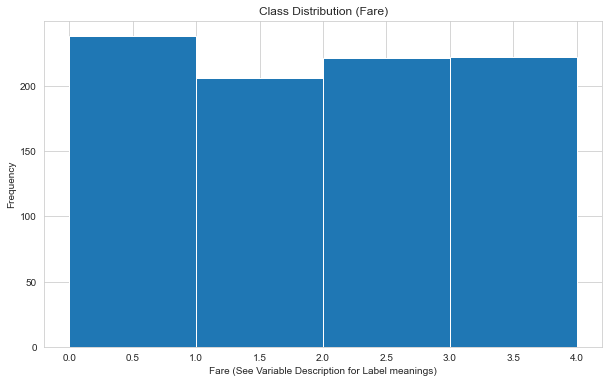

In [274]:
# Discretize the continuous values by binning them
df['Fare'] = pd.qcut(df['Fare'], q=4, labels=[0, 1, 2, 3], duplicates="drop")

# Reevaluate the data type of values in this column
print("The NEW data type of values in this column: " + str(df['Fare'].dtypes).capitalize())
print("")

# Reevaluate all of the unique values among records in this column
print("The NEW list of unique values among all records in this column:")
df['Fare'] = df['Fare'].astype(int) # To enable unique values to be sorted via .sort()
fare = df['Fare'].unique()
fare.sort()
print(fare)
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df.groupby('Fare').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Histogram:""")
plt.subplots(figsize=(10,6))
plt.hist(df['Fare'], bins = 4, range = (0,4))
plt.title('Class Distribution (Fare)')
plt.xlabel('Fare (See Variable Description for Label meanings)')
plt.ylabel('Frequency')
plt.show()

**Based on the above output:**

Variable #7: Fare (POST-DISCRETIZATION)
- Column Type: Category
- Four unique values: 0, 1, 2, and 3
- Class distribution: 0 occurs 238 times, 1 occurs 206 times, 2 occurs 221 times, 3 occurs 222 times
- Variable description: Originally represented in the data set as a continuous predictor variable with values being indicative of how much money a given passenger aboard the Titanic paid for their ticket (in USD). However, the decision tree model benefits from being given discrete variables for each stage of implementation. To discretize the Fare values 
into an easily interpretable form, all continuous values were divided into four separate discrete bins with each bin representing a percentile range (0 = 0th - 25th percentile, 1 = 26th to 50th percentile, 2 = 51st to 75th percentile, 3 = 76th to 100th percentile) of fares from the span of all values originally in the column.

#### Convert all columns to string type (Compatability)

In [275]:
# Convert all columns to string type to ensure compatability with the decision tree implementation
df = df.astype(str)

## Training the Decision Tree Model + Accuracy Report (Titanic)

#### Build and Train the Decision Tree Classifier

In [276]:
# Split the data into training and test sets
t_train, t_test = train_test_split(df, test_size=0.2, random_state = 1)

# Initialize the decision tree object and provide (1) the entire training set and (2) the training labels as arguments
titanic_clf = DecisionTree(t_train, t_train.Survived)

# Train the decision tree classifier
titanic_clf.train()

# Use the trained classifier to predict target labels in the test set and calculate an accuracy metric
t_test_result, t_test_accuracy = titanic_clf.predict(t_test.drop("Survived", axis=1), t_test["Survived"])

#### Decision Tree Classifier Accuracy Report

In [277]:
# The accuracy of the decision tree classifier at being able to predict target labels in the test set
print("Test Accuracy: " + str(t_test_accuracy*100) + "%")

Test Accuracy: 82.02247191011236%


**INTERPRETATION:** The decision tree classifier was determined to be 82.02247191011236 percent accurate when used on the test data, indicating that the classifier accurately predicted the target label of whether a Titanic passenger survived or not during 82.02247191011236 percent of opportunities

#### Confusion Matrix

In [278]:
# Generate a confusion matrix to better assess the classifier's accuracy at predicting target labels in the test set
print("The Decision Tree's confusion matrix relative to the test set:")
confusion = confusion_matrix(t_test_result['actual'], t_test_result['prediction'], labels=['0','1'])
print(confusion)

The Decision Tree's confusion matrix relative to the test set:
[[92 14]
 [18 54]]


**The Confusion Matrix communicates the following:** *(NOTE: ** = Value on Main Diagonal of Matrix)*

* ** The model accurately predicted that the target label would be '0' (i.e., a passenger did NOT survive) when the target label was indeed '0' (i.e., the passenger in fact did NOT survive) during 92 instances.

* ** The model accurately predicted that the target label would be '1' (i.e., a passenger DID survive) when the target label was indeed '1' (i.e., the passenger in fact DID survive) during 54 instances.

* The model inaccurately predicted that the target label would be '1' (i.e., a passenger DID survive) when the target label was instead '0' (i.e., the passenger actually did NOT survive) during 14 instances.

* The model accurately predicted that the target label would be '0' (i.e., a passenger did NOT survive) when the target label was instead '1' (i.e., the passenger actually DID survive) during 18 instances.

**Conclusion:** We can be confident in the accuracy of the confusion matrix's depiction of the decision tree classifier's accuracy because it accurately predicted the target label (i.e., a passenger's survival status) during 146 out of a possible 178 instances, which is equal to an accuracy metric of 82.02247191011236 percent.

# Part 3: Car Evaluation Data Set

## Data Preprocessing/Analysis (Car Evaluation)

#### Read in the data set and establish its dimensions/missing values

In [279]:
# Read in the Car Evaluation data set
df2 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data", header=None,
    names=["buying_price", "maintenance_price", "door_count", "person_capacity", "trunk_size", "safety_rating", "car_acceptability"],
)

# Establish the dimensions of the Car Evaluation data set
print("Dimensions of the Car Evaluation data set: " + str(df2.shape))
print("")

# Preemptively drop any rows with missing values from the data frame
df2 = df2.dropna(axis=0)
df2.reset_index(drop=True)

# Determine if any rows were dropped due to at least one column within said row having a missing value
print("Dimensions of the Car Evaluation data set (AFTER dropping rows with missing values): " + str(df2.shape))

Dimensions of the Car Evaluation data set: (1728, 7)

Dimensions of the Car Evaluation data set (AFTER dropping rows with missing values): (1728, 7)


**Based on the above output:**

- BEFORE attempting to drop rows with missing columns, the dimensions of the Car Evaluation data set were: 1728 rows and 7 columns
    - Representing 1728 cars across 7 variables

- AFTER dropping dropping rows with missing values, the dimensions of the Car Evaluation data set were: 1728 rows and 7 columns
  - *(NOTE: Since no rows were dropped, this result indicates that no rows were missing values.)*

#### Identify the variables in the Car Evaluation data frame

In [280]:
# Identify the variables in the data frame
print("A list of variables in the Car Evaluation data frame and each column's respective value type:")
print("")
print(df2.dtypes)

A list of variables in the Car Evaluation data frame and each column's respective value type:

buying_price         object
maintenance_price    object
door_count           object
person_capacity      object
trunk_size           object
safety_rating        object
car_acceptability    object
dtype: object


**Based on the above output:**

The Car Evaluation data set contains the following seven variables:
1. buying_price
2. maintenance_price
3. door_count
4. person_capacity
5. trunk_size
6. safety_rating
7. car_acceptability

***NOTE: Each variable will be further processed and analayzed in the subsequent cells.***

#### Variable 1: buying_price

The data type of values in this column: object

The list of unique values among all records in this column: ['high' 'low' 'med' 'vhigh']

The class distribution of values in this column:
buying_price
high     432
low      432
med      432
vhigh    432
dtype: int64

Class Distribution Bar Chart:


(0.0, 500.0)

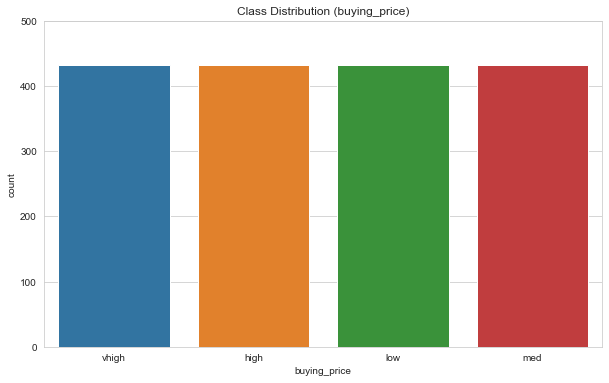

In [281]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df2['buying_price'].dtypes))
print("")

# Identify all of the unique values among records in this column
buying_price = df2['buying_price'].unique()
buying_price.sort()
print("The list of unique values among all records in this column: " + str(buying_price))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df2.groupby('buying_price').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
plt.subplots(figsize=(10,6))
sns.countplot(x = 'buying_price', data = df2, order = df2['buying_price'].value_counts().index).set_title("Class Distribution (buying_price)")
plt.ylim(0, 500)

**Based on the above output:**

Variable #1: buying_price
- Column Type: Object
- Four unique values: 'low', 'med', 'high', and 'vhigh'
- Class distribution: Each unique value occurs 432 times, respectively
- Variable description: A predictor variable that indicates the buying price of any given car in the data set. The column contains four unique string-type values: 'low' (i.e., a car has a low buying price), 'med' (i.e., a car has a medium buying price), 'high' (i.e., a car has a high buying price), and 'vhigh' (i.e., a car has a very high buying price).

#### Variable 2: maintenance_price

The data type of values in this column: object

The list of unique values among all records in this column: ['high' 'low' 'med' 'vhigh']

The class distribution of values in this column:
maintenance_price
high     432
low      432
med      432
vhigh    432
dtype: int64

Class Distribution Bar Chart:


(0.0, 500.0)

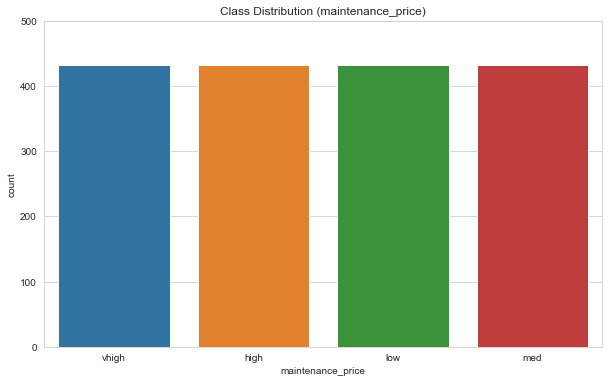

In [282]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df2['maintenance_price'].dtypes))
print("")

# Identify all of the unique values among records in this column
maintenance_price = df2['maintenance_price'].unique()
maintenance_price.sort()
print("The list of unique values among all records in this column: " + str(maintenance_price))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df2.groupby('maintenance_price').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
plt.subplots(figsize=(10,6))
sns.countplot(x = 'maintenance_price', data = df2, order = df2['maintenance_price'].value_counts().index).set_title("Class Distribution (maintenance_price)")
plt.ylim(0, 500)

**Based on the above output:**

Variable #2: maintenance_price
- Column Type: Object
- Four unique values: 'low', 'med', 'high', and 'vhigh'
- Class distribution: Each unique value occurs 432 times, respectively
- Variable description: A predictor variable that indicates the maintenance price of any given car in the data set. The column contains four unique string-type values: 'low' (i.e., a car has a low maintenance price), 'med' (i.e., a car has a medium maintenance price), 'high' (i.e., a car has a high maintenance price), and 'vhigh' (i.e., a car has a very high 
maintenance price).

#### Variable 3: door_count

The data type of values in this column: object

The list of unique values among all records in this column: ['2' '3' '4' '5more']

The class distribution of values in this column:
door_count
2        432
3        432
4        432
5more    432
dtype: int64

Class Distribution Bar Chart:


(0.0, 500.0)

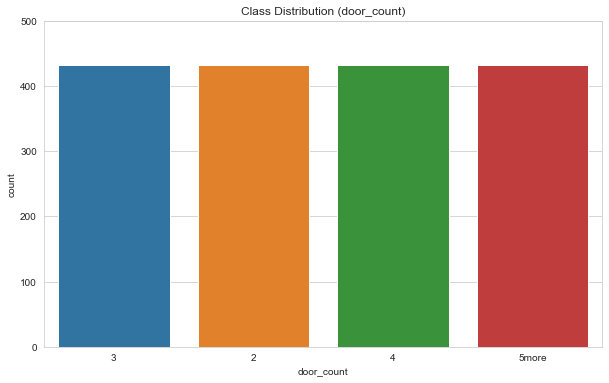

In [283]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df2['door_count'].dtypes))
print("")

# Identify all of the unique values among records in this column
door_count = df2['door_count'].unique()
door_count.sort()
print("The list of unique values among all records in this column: " + str(door_count))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df2.groupby('door_count').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
plt.subplots(figsize=(10,6))
sns.countplot(x = 'door_count', data = df2, order = df2['door_count'].value_counts().index).set_title("Class Distribution (door_count)")
plt.ylim(0, 500)

**Based on the above output:**

Variable #3: door_count
- Column Type: Object
- Four unique values: '2', '3', '4', and '5more'
- Class distribution: Each unique value occurs 432 times, respectively
- Variable description: A predictor variable that indicates the number of doors that any given car in the data set has. The column contains four unique string-type values: 2 (i.e., a car has 2 doors), 3 (i.e., a car has 3 doors), 4 (i.e., a car has 4 doors), and'5more' (i.e., a car has 5 or more doors).

#### Variable 4: person_capacity

The data type of values in this column: object

The list of unique values among all records in this column: ['2' '4' 'more']

The class distribution of values in this column:
person_capacity
2       576
4       576
more    576
dtype: int64

Class Distribution Bar Chart:


(0.0, 600.0)

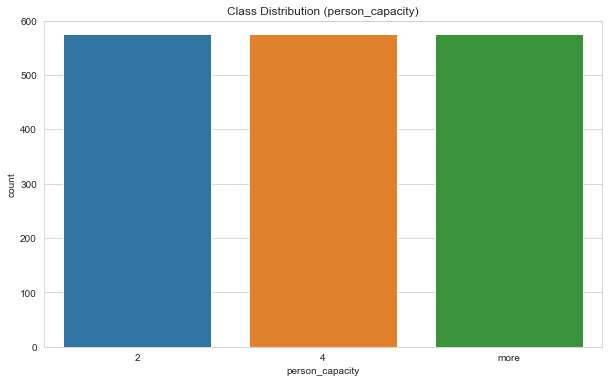

In [284]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df2['person_capacity'].dtypes))
print("")

# Identify all of the unique values among records in this column
person_capacity = df2['person_capacity'].unique()
person_capacity.sort()
print("The list of unique values among all records in this column: " + str(person_capacity))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df2.groupby('person_capacity').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
plt.subplots(figsize=(10,6))
sns.countplot(x = 'person_capacity', data = df2, order = df2['person_capacity'].value_counts().index).set_title("Class Distribution (person_capacity)")
plt.ylim(0, 600)

**Based on the above output:**

Variable #4: person_capacity
- Column Type: Object
- Three unique values: '2', '4', and 'more'
- Class distribution: Each unique value occurs 576 times, respectively
- Variable description: A predictor variable that indicates the maximum capacity of persons that can fit inside of any given car in the data set. The column contains three unique string-type values: 2 (i.e., a car fits 2 people), 4 (i.e., a car fits 4 people), and 'more' (i.e., a car fits more than 4 people).

#### Variable 5: trunk_size

The data type of values in this column: object

The list of unique values among all records in this column: ['big' 'med' 'small']

The class distribution of values in this column:
trunk_size
big      576
med      576
small    576
dtype: int64

Class Distribution Bar Chart:


(0.0, 600.0)

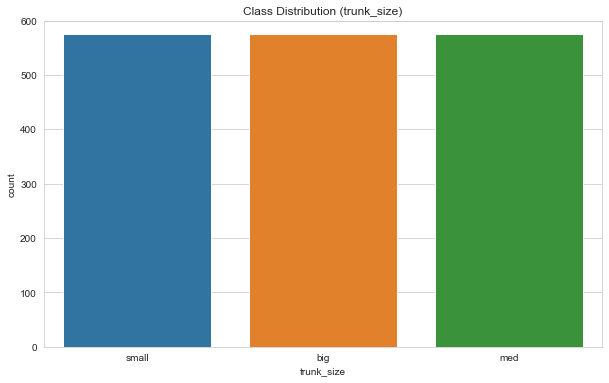

In [285]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df2['trunk_size'].dtypes))
print("")

# Identify all of the unique values among records in this column
trunk_size = df2['trunk_size'].unique()
trunk_size.sort()
print("The list of unique values among all records in this column: " + str(trunk_size))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df2.groupby('trunk_size').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
plt.subplots(figsize=(10,6))
sns.countplot(x = 'trunk_size', data = df2, order = df2['trunk_size'].value_counts().index).set_title("Class Distribution (trunk_size)")
plt.ylim(0, 600)

**Based on the above output:**

Variable #5: trunk_size
- Column Type: Object
- Three unique values: 'small', 'med', and 'big'
- Class distribution: Each unique value occurs 576 times, respectively
- Variable description: A predictor variable that indicates the size of the trunk for any given car in the data set. The column contains three unique string-type values: 'small' (i.e., a car has a small-sized trunk), 'med' (i.e., a car has a medium-sized trunk), and 'big' (i.e., a car has a big-sized trunk).

#### Variable 6: safety_rating

The data type of values in this column: object

The list of unique values among all records in this column: ['high' 'low' 'med']

The class distribution of values in this column:
safety_rating
high    576
low     576
med     576
dtype: int64

Class Distribution Bar Chart:


(0.0, 600.0)

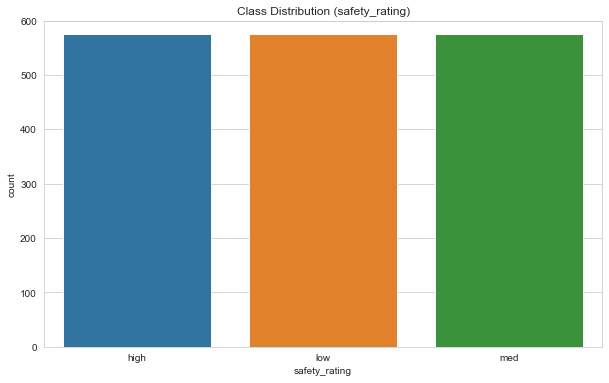

In [286]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df2['safety_rating'].dtypes))
print("")

# Identify all of the unique values among records in this column
safety_rating = df2['safety_rating'].unique()
safety_rating.sort()
print("The list of unique values among all records in this column: " + str(safety_rating))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df2.groupby('safety_rating').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
plt.subplots(figsize=(10,6))
sns.countplot(x = 'safety_rating', data = df2, order = df2['safety_rating'].value_counts().index).set_title("Class Distribution (safety_rating)")
plt.ylim(0, 600)

**Based on the above output:**

Variable #6: safety_rating
- Column Type: Object
- Three unique values: 'low', 'med', and 'high'
- Class distribution: Each unique value occurs 576 times, respectively
- Variable description: A predictor variable that indicates the safety rating for any given car in the data set. The column contains three unique string-type values: 'low' (i.e., a car has a low safety rating), 'med' (i.e., a car has a medium safety rating), and 'high' (i.e., a car has a high safety rating).

#### Variable 7: car_acceptability

The data type of values in this column: object

The list of unique values among all records in this column: ['acc' 'good' 'unacc' 'vgood']

The class distribution of values in this column:
car_acceptability
acc       384
good       69
unacc    1210
vgood      65
dtype: int64

Class Distribution Bar Chart:


(0.0, 1250.0)

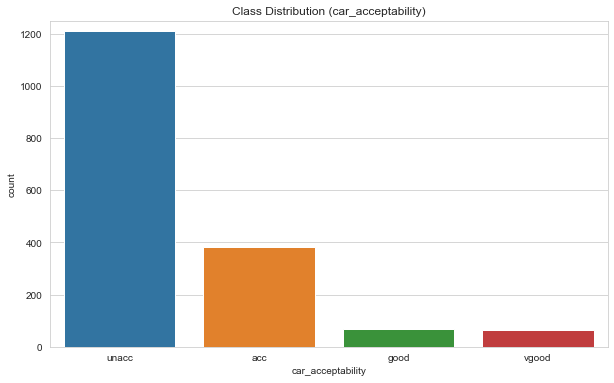

In [287]:
# Identify the data type of values in this column
print("The data type of values in this column: " + str(df2['car_acceptability'].dtypes))
print("")

# Identify all of the unique values among records in this column
car_acceptability = df2['car_acceptability'].unique()
car_acceptability.sort()
print("The list of unique values among all records in this column: " + str(car_acceptability))
print("")

# Generate a class distribution for values in this column
print("The class distribution of values in this column:")
print(df2.groupby('car_acceptability').size())
print("")

# Generate a bar chart to better visualize the class distribution
print("""Class Distribution Bar Chart:""")
plt.subplots(figsize=(10,6))
sns.countplot(x = 'car_acceptability', data = df2, order = df2['car_acceptability'].value_counts().index).set_title("Class Distribution (car_acceptability)")
plt.ylim(0, 1250)

**Based on the above output:**

Variable #7: car_acceptability
- Column Type: Object
- Four unique values: 'unacc', 'acc', 'good', and 'vgood'
- Class distribution: 'unacc' occurs 1210 times, 'acc' occurs 384 times, 'good' occurs 69 times, and 'vgood' occurs 65 times
- Variable description: A response variable that indicates the overall acceptability for any given car in the data set. The column contains four unique string-type values: 'unacc' (i.e., a car is in unacceptable condition), 'acc' (i.e., a car is in acceptable condition), 'good' (i.e., a car is in good condition), and 'vgood' (i.e., a car is in very
good condition).

## Training the Decision Tree Model + Accuracy Report (Car Evaluation)

#### Build and Train the Decision Tree Classifier

In [288]:
# Split the data into training and test sets
c_train, c_test = train_test_split(df2, test_size=0.2, random_state = 1)

# Initialize the decision tree object and provide (1) the entire training set and (2) the training labels as arguments
cars_clf = DecisionTree(c_train, c_train.car_acceptability)

# Train the decision tree classifier
cars_clf.train()

# Use the trained classifier to predict target labels in the test set and calculate an accuracy metric
c_test_result, c_test_accuracy = cars_clf.predict(c_test.drop("car_acceptability", axis=1), c_test["car_acceptability"])

#### Decision Tree Classifier Accuracy Report

In [289]:
# The accuracy of the decision tree classifier at being able to predict target labels in the test set
print("Test Accuracy: " + str(c_test_accuracy*100) + "%")

Test Accuracy: 90.17341040462428%


**INTERPRETATION:** The decision tree classifier was determined to be 90.17341040462428 percent accurate when used on the test data, indicating that the classifier accurately predicted the target label of a car's acceptability rating during 90.17341040462428 percent of opportunities.

#### Confusion Matrix

In [290]:
# Generate a confusion matrix to better assess the classifier's accuracy at predicting target labels in the test set
print("The Decision Tree's confusion matrix relative to the test set:")
confusion = confusion_matrix(c_test_result['actual'], c_test_result['prediction'], labels = ['unacc','acc','good','vgood'])
print(confusion)

The Decision Tree's confusion matrix relative to the test set:
[[248  12   0   0]
 [ 11  46   1   1]
 [  3   0  10   1]
 [  5   0   0   8]]


**The FIRST ROW of the confusion matrix communicates the following:** *(NOTE: ** = Value on Main Diagonal of Matrix)*

- ** The model accurately predicted that the target label would be 'unacc' (i.e., a car would have an acceptability rating of "unacceptable") when the target label was indeed 'unacc' (i.e., the car in fact had an acceptability rating of "unacceptable") during 248 instances.

- The model inaccurately predicted that the target label would be 'acc' (i.e., a car would have an acceptability rating of "acceptable") when the target label was instead 'unacc' (i.e., the car actually had an acceptability rating of "unacceptable") during 12 instances.

- The model inaccurately predicted that the target label would be 'good' (i.e., a car would have an acceptability rating of "good") when the target label was instead 'unacc' (i.e., the car actually had an acceptability rating of "unacceptable") during 0 instances.

- The model inaccurately predicted that the target label would be 'vgood' (i.e., a car would have an acceptability rating of "very good") when the target label was instead 'unacceptable' (i.e., the car actually had an acceptability rating of "unacceptable") during 0 instances.

**The SECOND ROW of the confusion matrix communicates the following:** *(NOTE: ** = Value on Main Diagonal of Matrix)*

- ** The model accurately predicted that the target label would be 'acc' (i.e., a car would have an acceptability rating of "acceptable") when the target label was indeed 'acc' (i.e., the car in fact had an acceptability rating of "acceptable") during 46 instances.

- The model inaccurately predicted that the target label would be 'unacc' (i.e., a car would have an acceptability rating of "unacceptable") when the target label was instead 'acc' (i.e., the car actually had an acceptability rating of "acceptable") during 11 instances.

- The model inaccurately predicted that the target label would be 'good' (i.e., a car would have an acceptability rating of "good") when the target label was instead 'acc' (i.e., the car actually had an acceptability rating of "acceptable") during 1 instances.

- The model inaccurately predicted that the target label would be 'vgood' (i.e., a car would have an acceptability rating of "very good") when the target label was instead 'acc' (i.e., the car actually had an acceptability rating of "acceptable") during 1 instances.

**The THIRD ROW of the confusion matrix communicates the following:** *(NOTE: ** = Value on Main Diagonal of Matrix)*

- ** The model accurately predicted that the target label would be 'good' (i.e., a car would have an acceptability rating of "good") when the target label was indeed 'good' (i.e., the car in fact had an acceptability rating of "good") during 10 instances.

- The model inaccurately predicted that the target label would be 'unacc' (i.e., a car would have an acceptability rating of "unacceptable") when the target label was instead 'good' (i.e., the car actually had an acceptability rating of "good") during 3 instances.

- The model inaccurately predicted that the target label would be 'acc' (i.e., a car would have an acceptability rating of "acceptable") when the target label was instead 'good' (i.e., the car actually had an acceptability rating of "good") during 0 instances.

- The model inaccurately predicted that the target label would be 'vgood' (i.e., a car would have an acceptability rating of "very good") when the target label was instead 'good' (i.e., the car actually had an acceptability rating of "good") during 1 instances.

**The FOURTH ROW of the confusion matrix communicates the following:** *(NOTE: ** = Value on Main Diagonal of Matrix)*

- ** The model accurately predicted that the target label would be 'vgood' (i.e., a car would have an acceptability rating of "very good") when the target label was indeed 'vgood' (i.e., the car in fact had an acceptability rating of "very good") during 8 instances.

- The model inaccurately predicted that the target label would be 'unacc' (i.e., a car would have an acceptability rating of "unacceptable") when the target label was instead 'vgood' (i.e., the car actually had an acceptability rating of "very good") during 5 instances.

- The model inaccurately predicted that the target label would be 'acc' (i.e., a car would have an acceptability rating of "acceptable") when the target label was instead 'vgood' (i.e., the car actually had an acceptability rating of "very good") during 0 instances.

- The model inaccurately predicted that the target label would be 'good' (i.e., a car would have an acceptability rating of "good") when the target label was instead 'vgood' (i.e., the car actually had an acceptability rating of "very good") during 0 instances.

**CONCLUSION:** We can be confident in the accuracy of the confusion matrix's depiction of the decision tree classifier's accuracy because it accurately predicted the target label (i.e., a car's acceptability rating) during 312 out of a possible 346 instances, which is equal to the classifier's accuracy metric of 90.17341040462428 percent.